# Lab 3: Data Cleaning and Visualization

In this lab, you will be working with a dataset from the City of Berkeley containing data on calls to the Berkeley Police Department. Information about the dataset can be found [at this link](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).



## Setup

Note that after activating matplotlib to display figures inline via the IPython magic `%matplotlib inline`, we configure a custom default figure size. Virtually every default aspect of matplotlib [can be customized](https://matplotlib.org/users/customizing.html).

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 9)

# Part 1: Cleaning and Exploring the Data

To retrieve the dataset, we will use the `ds100_utils.fetch_and_cache` utility.

In [3]:
import ds100_utils

data_dir = 'data'
data_url = 'http://www.ds100.org/sp19/assets/datasets/lab03_data_sp19.zip'
file_name = 'lab03_data_sp19.zip'

dest_path = ds100_utils.fetch_and_cache(data_url=data_url, file=file_name, data_dir=data_dir)
print(f'Located at {dest_path}')

Using cached version that was downloaded (UTC): Tue Jul  2 22:41:40 2019
Located at data\lab03_data_sp19.zip


We will now directly unzip the ZIP archive and start working with the uncompressed files.

Note: There is no single right answer regarding whether to work with compressed files in their compressed state or to uncompress them on disk permanently. If you for example need to work with multiple tools on the same files, or write many notebooks to analyze them, and they are not too large, it may be more convenient to uncompress them once.  But you may also have situations where you find it preferable to work with the compressed data directly.  

Python gives you tools for both approaches, and you should know how to perform both tasks in order to choose the one that best suits the problem at hand.

---

Run the cell below to extract the zip file into the data directory.

In [4]:
my_zip = zipfile.ZipFile(dest_path, 'r')
my_zip.extractall(data_dir)

Now, we'll use a method of the `Pathlib.Path` class called `glob` to list all files in the `data` directory. You will find useful information in pathlib [docs](https://docs.python.org/3/library/pathlib.html).

Below, we use pathlib's `glob` method to store the list of all files' names from the `data_dir` directory in the variable `file_names`. These names should be strings that contain only the file name (e.g. `dummy.txt` not `data/dummy.txt`). The asterisk (*) character is used with the `glob` method to match any string.

In [5]:
from pathlib import Path
data_dir_path = Path('data') # creates a Path object that points to the data directory
file_names = [x.name for x in data_dir_path.glob('*') if x.is_file()]
file_names

['ben_kurtovic.py',
 'Berkeley_PD_-_Calls_for_Service.csv',
 'do_not_readme.md',
 'dummy.txt',
 'hello_world.py',
 'lab03_data_sp19.zip']

Let's now load the CSV file we have into a `pandas.DataFrame` object.

In [6]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...",OREGON STREET & MCGEE AVE,Berkeley,CA
1,18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...",200 UNIVERSITY AVE,Berkeley,CA
2,18038550,THEFT MISD. (UNDER $950),05/18/2018 12:00:00 AM,20:00,LARCENY,5,09/06/2018 03:30:09 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA
3,18014810,BURGLARY AUTO,03/13/2018 12:00:00 AM,08:50,BURGLARY - VEHICLE,2,09/06/2018 03:30:08 AM,"1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....",1200 SIXTH ST,Berkeley,CA
4,18018643,ALCOHOL OFFENSE,03/31/2018 12:00:00 AM,13:29,LIQUOR LAW VIOLATION,6,09/06/2018 03:30:11 AM,"CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...",CENTER STREET & SHATTUCK AVE,Berkeley,CA


We see that the fields include a case number, the offense type, the date and time of the offense, the "CVLEGEND" which appears to be related to the offense type, a "CVDOW" which has no apparent meaning, a date added to the database, and the location spread across four fields.

Let's also check some basic information about these files using the `DataFrame.describe` and `DataFrame.info` methods.

In [7]:
calls.info()
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 11 columns):
CASENO            3788 non-null int64
OFFENSE           3788 non-null object
EVENTDT           3788 non-null object
EVENTTM           3788 non-null object
CVLEGEND          3788 non-null object
CVDOW             3788 non-null int64
InDbDate          3788 non-null object
Block_Location    3788 non-null object
BLKADDR           3766 non-null object
City              3788 non-null object
State             3788 non-null object
dtypes: int64(2), object(9)
memory usage: 325.7+ KB


,CASENO,CVDOW
count,3.788000e+03,3788.000000
mean,1.804387e+07,2.997888
std,2.665970e+04,1.952160
min,1.801375e+07,0.000000
25%,1.802444e+07,1.000000
50%,1.803530e+07,3.000000
75%,1.804537e+07,5.000000
max,1.809135e+07,6.000000


Notice that the functions above reveal type information for the columns, as well as some basic statistics about the numerical columns found in the DataFrame. However, we still need more information about what each column represents. Let's explore the data further in Question 1.

Before we go over the fields to see their meanings, the cell below will verify that all the events happened in Berkeley by grouping on the `City` and `State` columns. You should see that all of our data falls into one group.

In [8]:
calls.groupby(["City","State"]).count()

,,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR
City,State,,,,,,,,,
Berkeley,CA,3788,3788,3788,3788,3788,3788,3788,3788,3766


## Question 1
Above, when we called `head`, it seemed like `OFFENSE` and `CVLEGEND` both contained information about the type of event reported. What is the difference in meaning between the two columns? One way to probe this is to look at the `value_counts` for each Series.

In [9]:
calls['OFFENSE'].value_counts().head(10)

BURGLARY AUTO               658
THEFT MISD. (UNDER $950)    633
DISTURBANCE                 277
VANDALISM                   248
VEHICLE STOLEN              235
THEFT FELONY (OVER $950)    214
BURGLARY RESIDENTIAL        194
ASSAULT/BATTERY MISD.       190
ROBBERY                     168
NARCOTICS                   118
Name: OFFENSE, dtype: int64

In [13]:
calls['CVLEGEND'].value_counts().head(10)

LARCENY                   871
BURGLARY - VEHICLE        658
DISORDERLY CONDUCT        279
ASSAULT                   263
VANDALISM                 248
MOTOR VEHICLE THEFT       235
FRAUD                     208
BURGLARY - RESIDENTIAL    194
ROBBERY                   168
DRUG VIOLATION            118
Name: CVLEGEND, dtype: int64

### Question 1a

Above, it seems like `OFFENSE` is more specific than `CVLEGEND`, e.g. "LARCENY" vs. "THEFT FELONY (OVER $950)". For those of you who don't know the word "larceny", it's a legal term for theft of personal property.

To get a sense of how many subcategories there are for each `OFFENSE`, set `calls_by_cvlegend_and_offense` equal to a multi-indexed series where the data is first indexed on the `CVLEGEND` and then on the `OFFENSE`, and the data is equal to the number of offenses in the database that match the respective `CVLEGEND` and `OFFENSE`. For example, calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"] should return 24.


In [30]:
calls_by_cvlegend_and_offense = calls.groupby(['CVLEGEND', 'OFFENSE'])['OFFENSE'].count()
# calls_by_cvlegend_and_offense["LARCENY", "THEFT FROM PERSON"]
calls_by_cvlegend_and_offense

CVLEGEND                OFFENSE                 
ALL OTHER OFFENSES      MUNICIPAL CODE                3
ARSON                   ARSON                        18
ASSAULT                 ASSAULT/BATTERY FEL.         73
                        ASSAULT/BATTERY MISD.       190
BURGLARY - COMMERCIAL   BURGLARY COMMERCIAL         112
BURGLARY - RESIDENTIAL  BURGLARY RESIDENTIAL        194
BURGLARY - VEHICLE      BURGLARY AUTO               658
DISORDERLY CONDUCT      DISTURBANCE                 277
                        VICE                          2
DRUG VIOLATION          NARCOTICS                   118
FAMILY OFFENSE          DOMESTIC VIOLENCE           108
FRAUD                   FRAUD/FORGERY                95
                        IDENTITY THEFT              113
HOMICIDE                HOMICIDE                      1
KIDNAPPING              KIDNAPPING                    6
LARCENY                 THEFT FELONY (OVER $950)    214
                        THEFT FROM PERSON            24

### Question 1b

In the cell below, set `answer1b` equal to a list of strings corresponding to the possible values for `OFFENSE` when `CVLEGEND` is "LARCENY". You can type the answer manually, or you can create an expression that automatically extracts the names.


In [14]:
# You may use this cell for your scratch work as long as you enter
# in your final answers in the answer1 variable.
answer1b = list(calls[calls['CVLEGEND'] == 'LARCENY']['OFFENSE'].unique())
answer1b

['THEFT MISD. (UNDER $950)', 'THEFT FELONY (OVER $950)', 'THEFT FROM PERSON']

## Question 2

What are the five crime types of CVLEGEND that have the most crime events? You may need to use `value_counts` to find the answer.
Save your results into `answer2` as a list of strings.

**Hint:** *The `keys` method of the Series class might be useful.*


In [16]:
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,18022300,DISTURBANCE,04/18/2018 12:00:00 AM,22:17,DISORDERLY CONDUCT,3,09/06/2018 03:30:12 AM,"OREGON STREET &amp; MCGEE AVE\nBerkeley, CA\n(...",OREGON STREET & MCGEE AVE,Berkeley,CA
1,18026683,THEFT MISD. (UNDER $950),05/09/2018 12:00:00 AM,21:25,LARCENY,3,09/06/2018 03:30:13 AM,"200 UNIVERSITY AVE\nBerkeley, CA\n(37.865511, ...",200 UNIVERSITY AVE,Berkeley,CA
2,18038550,THEFT MISD. (UNDER $950),05/18/2018 12:00:00 AM,20:00,LARCENY,5,09/06/2018 03:30:09 AM,"2200 MILVIA ST\nBerkeley, CA\n(37.868574, -122...",2200 MILVIA ST,Berkeley,CA
3,18014810,BURGLARY AUTO,03/13/2018 12:00:00 AM,08:50,BURGLARY - VEHICLE,2,09/06/2018 03:30:08 AM,"1200 SIXTH ST\nBerkeley, CA\n(37.881142, -122....",1200 SIXTH ST,Berkeley,CA
4,18018643,ALCOHOL OFFENSE,03/31/2018 12:00:00 AM,13:29,LIQUOR LAW VIOLATION,6,09/06/2018 03:30:11 AM,"CENTER STREET &amp; SHATTUCK AVE\nBerkeley, CA...",CENTER STREET & SHATTUCK AVE,Berkeley,CA


In [22]:
answer2 = list(calls.groupby(calls['CVLEGEND']).count()['EVENTDT'].sort_values(ascending = False)[0:5].keys())
answer2

['LARCENY', 'BURGLARY - VEHICLE', 'DISORDERLY CONDUCT', 'ASSAULT', 'VANDALISM']

---
# Part 2: Visualizing the Data

## Pandas vs. Seaborn Plotting

Pandas offers basic functionality for plotting. For example, the `DataFrame` and `Series` classes both have a `plot` method. However, the basic plots generated by pandas are not particularly pretty. While it's possible to manually use matplotlib commands to make pandas plots look better, we'll instead use a high level plotting library called Seaborn that will take care of most of this for us.

As you learn to do data visualization, you may find the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) and [Seaborn documentation](https://seaborn.pydata.org/api.html) helpful!

As an example of the built-in plotting functionality of pandas, the following example uses `plot` method of the `Series` class to generate a `barh` plot type to visually display the value counts for `CVLEGEND`.

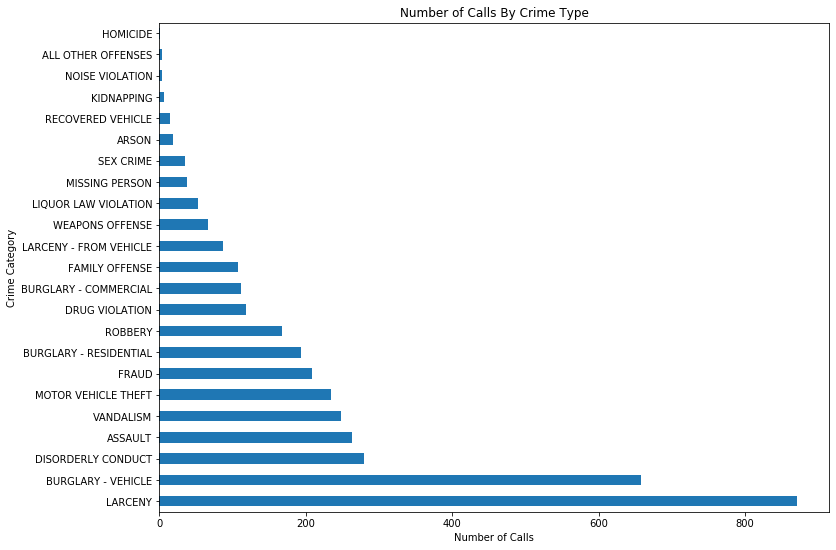

In [153]:
ax = calls['CVLEGEND'].value_counts().plot(kind='barh')
ax.set_ylabel("Crime Category")
ax.set_xlabel("Number of Calls")
ax.set_title("Number of Calls By Crime Type");

By contrast, the Seaborn library provides a specific function `countplot` built for plotting counts. It operates directly on the DataFrame itself i.e. there's no need to call `value_counts()` at all. This higher level approach makes it easier to work with. Run the cell below, and you'll see that the plot is much prettier (albeit in a weird order).

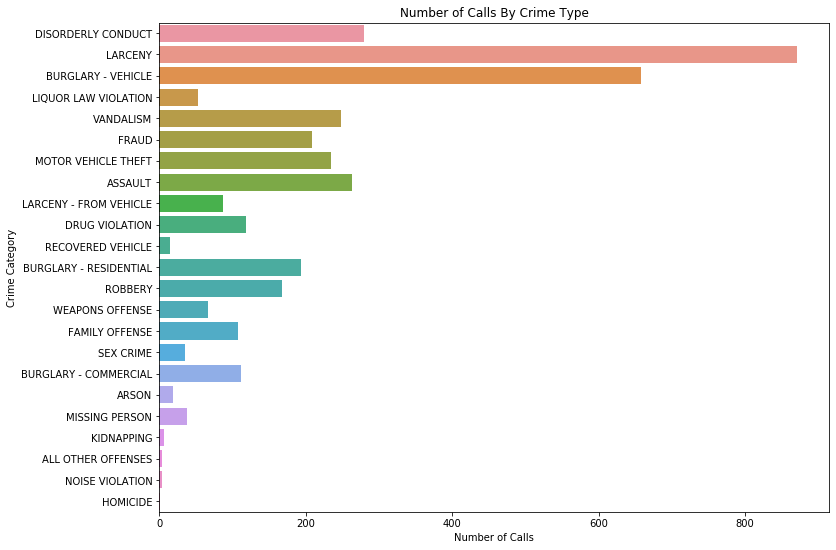

In [154]:
ax = sns.countplot(data=calls, y="CVLEGEND")
ax.set_ylabel("Crime Category")
ax.set_xlabel("Number of Calls")
ax.set_title("Number of Calls By Crime Type");

If we want the same ordering that we had in the pandas plot, we can use the order parameter of the `countplot` method. It takes a list of strings corresponding to the axis to be ordered. By passing the index of the `value_counts`, we get the order we want.

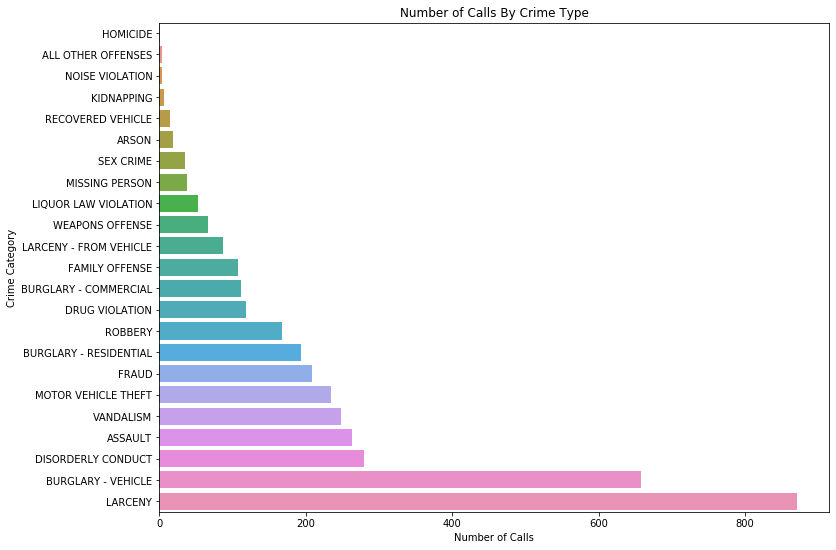

In [23]:
ax = sns.countplot(data=calls, y="CVLEGEND", order=calls["CVLEGEND"].value_counts(ascending=True).index);
ax.set_ylabel("Crime Category")
ax.set_xlabel("Number of Calls")
ax.set_title("Number of Calls By Crime Type");

Voilà! Now we have a pretty bar plot with the bars ordered by size. Though `seaborn` appears to provide a superior plot from a aesthetic point of view, the `pandas` plotting library is also good to understand. You'll get practice using both libraries in the following questions.

## An Additional Note on Plotting in Jupyter Notebooks

You may have noticed that many of our code cells involving plotting end with a semicolon (;). This prevents any extra output from the last line of the cell that we may not want to see. Try adding this to your own code in the following questions!

## Question 3

Now it is your turn to make some plots using `pandas` and `seaborn`. Let's start by looking at the distribution of calls over days of the week.

The CVDOW field isn't named helpfully and it is hard to see the meaning from the data alone. According to the website linked at the top of this notebook, CVDOW is actually indicating the day that events happened. 0->Sunday, 1->Monday ... 6->Saturday. 

### Question 3a

Add a new column `Day` into the `calls` dataframe that has the string weekday (eg. 'Sunday') for the corresponding value in CVDOW. For example, if the first 3 values of `CVDOW` are `[3, 6, 0]`, then the first 3 values of the `Day` column should be `["Wednesday", "Saturday", "Sunday"]`.

**Hint:** *Try using the [Series.map](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) function on `calls["CVDOW"]`.  Can you assign this to the new column `calls["Day"]`?*

```
BEGIN QUESTION
name: q3a
```

In [31]:
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
day_indices = range(7)
indices_to_days_dict = dict(zip(day_indices, days)) # Should look like {0:"Sunday", 1:"Monday", ..., 6:"Saturday"}
calls["Day"] = calls["CVDOW"].map(dict(zip(day_indices, days)))

### Question 3b

Run the cell below to create a `seaborn` plot. This plot shows the number of calls for each day of the week. Notice the use of the `rotation` argument in `ax.set_xticklabels`, which rotates the labels by 90 degrees.

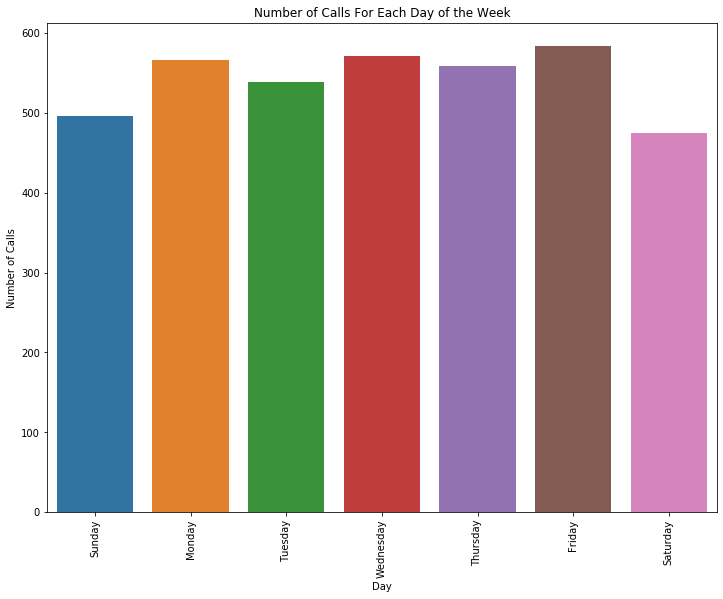

In [158]:
ax = sns.countplot(data=calls, x='Day', order=days)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls For Each Day of the Week");

Now, let's make the same plot using `pandas`. Construct a vertical bar plot with the count of the number of calls (entries in the table) for each day of the week **ordered by the day of the week** (eg. `Sunday`, `Monday`, ...). Do not use `sns` for this plot. Be sure that your axes are labeled and that your plot is titled.

**Hint:** *Given a series `s`, and an array `coolIndex` that has the same entries as in `s.index`, `s[coolIndex]` will return a copy of the series in the same order as `coolIndex`.*

```
BEGIN QUESTION
name: q3b
```

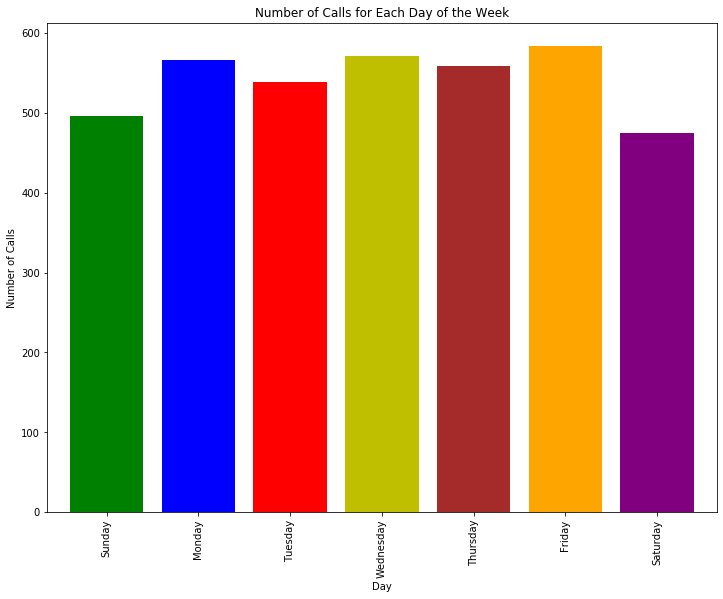

In [42]:
countframe = calls.groupby('Day')[['Day']].count()
s_index = ('Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday')
countframe = countframe.reindex(s_index)
countframe = countframe.rename({'Day':'Count'},axis = 1)
countframe = countframe.reset_index()
day_indices = range(7)
countframe['Count'].plot(kind = 'bar',color=tuple(["g", "b","r","y","brown",'orange','purple']),width=0.8)
plt.xticks(np.arange(7),s_index)
plt.ylabel('Number of Calls')
plt.xlabel('Day')
plt.title('Number of Calls for Each Day of the Week')


# # Leave this for grading purposes
ax_3b = plt.gca()

## Question 4

It seems weekdays generally have slightly more calls than Saturday or Sunday, but the difference does not look significant.  

We can break down into some particular types of events to see their distribution. For example, let's make a bar plot for the CVLEGEND "NOISE VIOLATION". Which day is the peak for "NOISE VIOLATION"?

### Question 4a

This time, use `seaborn` to create a vertical bar plot of the number of total noise violations reported on each day of the week, again ordered by the days of the week starting with Sunday. Do not use `pandas` to plot.

**Hint:** *If you're stuck, use the code for the seaborn plot in Question 3b as a starting point.*


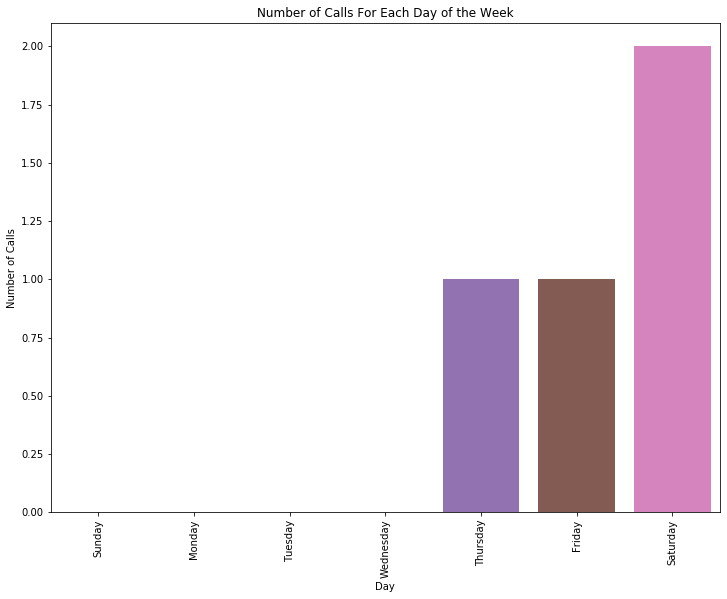

In [43]:
selectedone = calls[calls['CVLEGEND'] == 'NOISE VIOLATION']

ax = sns.countplot(data=selectedone, x='Day', order=days)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls For Each Day of the Week")
# Saturday is the peak for 'NOISE VIOLATION'

# Leave this for grading purposes
ax_4a = plt.gca()

### Question 4b

Do you realize anything interesting about the distribution of NOISE VIOLATION calls over a week? Type a 1-sentence answer in the cell below.

The distribution of NOISE VIOLATION is only on Thursday, Friday and Saturday and reaches a peak on Saturday.

## Question 5

Let's look at a similar distribution but for a crime we have much more calls data about. In the cell below, create the same plot as you did in Question 4, but now looking at instances of the CVLEGEND "FRAUD" (instead of "NOISE VIOLATION"). Use either `pandas` or `seaborn` plotting as you desire.


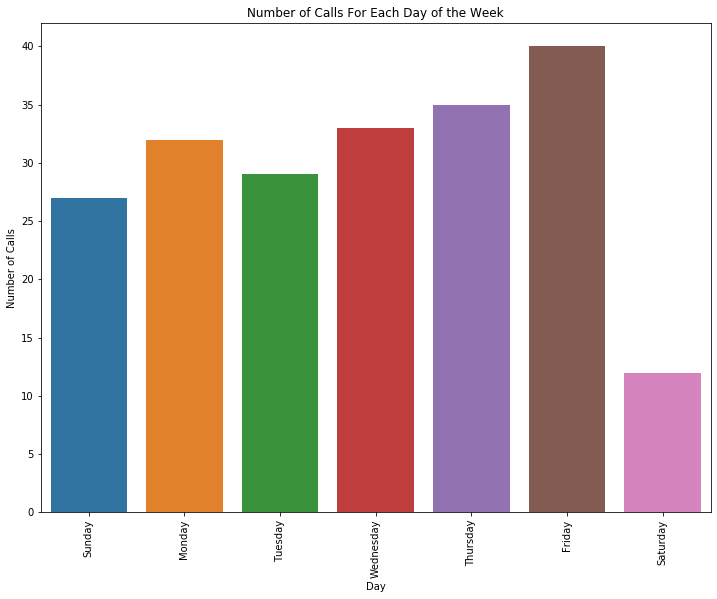

In [44]:
selectedFRAUD = calls[calls['CVLEGEND'] == 'FRAUD']

ax = sns.countplot(data=selectedFRAUD, x='Day', order=days)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls For Each Day of the Week");

# Leave this for grading purposes
ax_5 = plt.gca()

## Question 6

### Question 6a

Now let's look at the EVENTTM column which indicates the time for events. Since it contains hour and minute information, let's extract the hour info and create a new column named `Hour` in the `calls` dataframe. You should save the hour as an `int`. Then plot the frequency of each hour in the table (i.e., `value_counts()`) sorted by the hour of the day (i.e., `sort_index()`).

You will want to look into how to use:

* [Series.str.slice](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.slice.html#pandas.Series.str.slice) to select the substring.
* [Series.astype](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html) to change the type.

**Hint:** *The `str` helper member of a series can be used to grab substrings.  For example, `calls["EVENTTM"].str.slice(3,5)` returns the minute of each hour of the `EVENTTM`.*


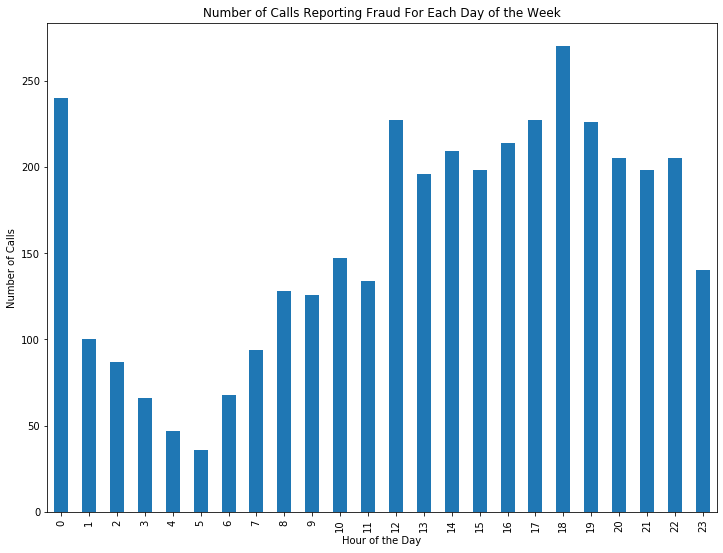

In [47]:
calls['Hour'] = calls['EVENTTM'].str.slice(0,2).astype('int64')
ax = calls['Hour'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week");

The code in the cell below creates a pandas bar plot showing the number of FRAUD crimes committed at each hour of the day.

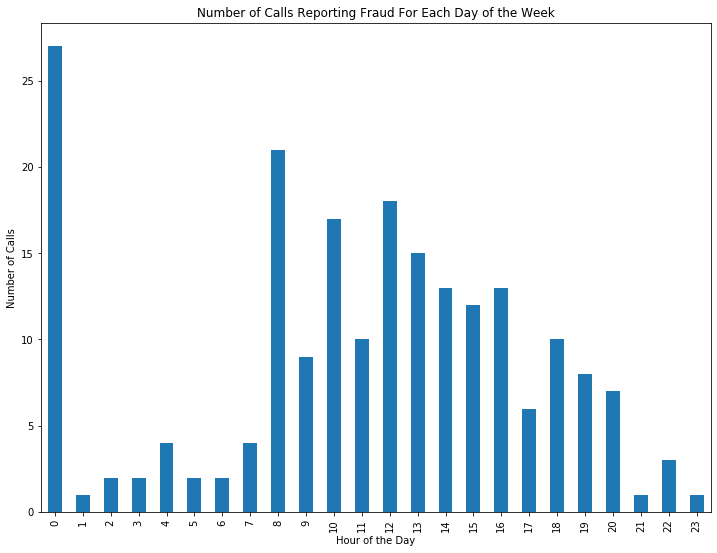

In [48]:
ax = calls[calls["CVLEGEND"] == "FRAUD"]['Hour'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week");

The cell below contains a seaborn plot of the same data.

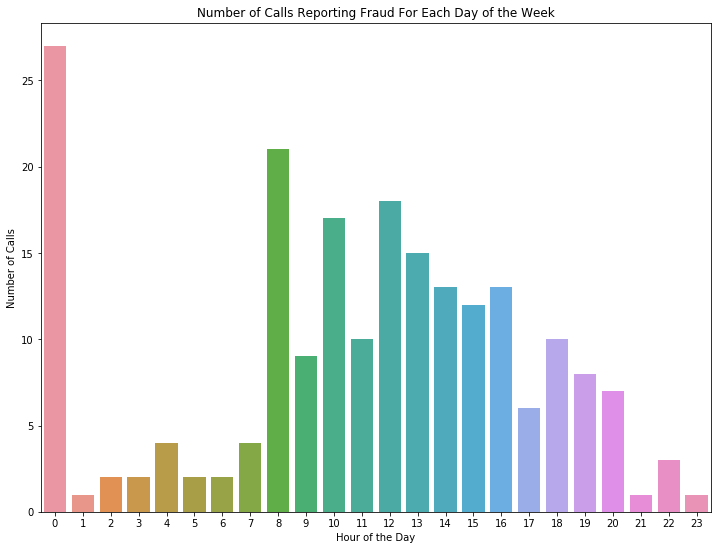

In [52]:
ax = sns.countplot(calls[calls["CVLEGEND"] == "FRAUD"]['Hour'])
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Number of Calls")
ax.set_title("Number of Calls Reporting Fraud For Each Day of the Week");
#alternate solution: sns.countplot(data=calls[calls["CVLEGEND"] == "FRAUD"], x = 'Hour');

### Question 6b

According to our plots, there seems to be a spike in calls reporting fraud at midnight. Do you trust that this spike is legitimate, or could there be an issue with our data? Explain your reasoning in 1-2 sentences in the cell below.

Actually I doubt the spike in calls reporting fraud at midnight, because most people are sleeping at that time, they cannot aware whether there is a fraud. So less calls at midnight does not mean less fraud at midnight.

## Question 7 (OPTIONAL)

In the cell below, we generate a boxplot which examines the hour of day of each crime broken down by the `CVLEGEND` value.  To construct this plot we used the [DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html) documentation.

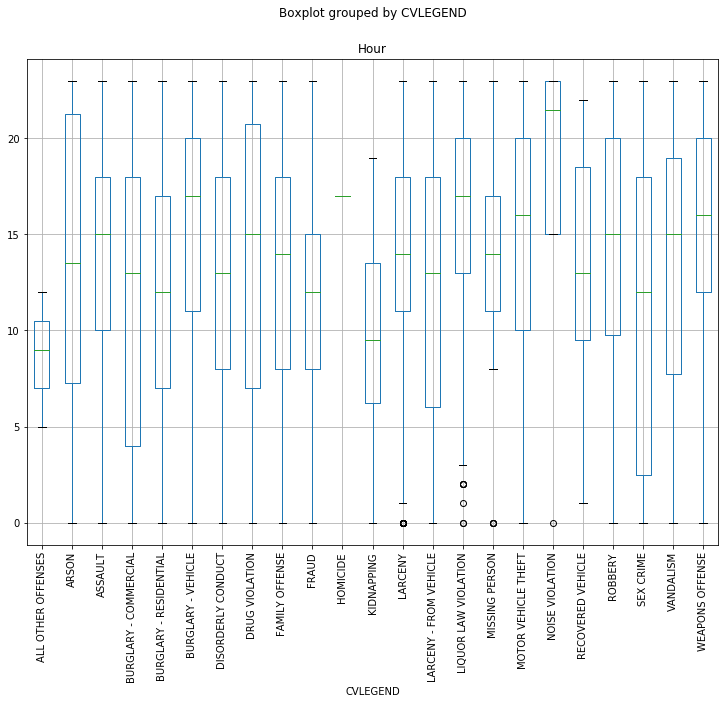

In [170]:
calls.boxplot(column="Hour", by='CVLEGEND', rot=90);

While the pandas boxplot is informative, we can use seaborn to create a more visually-appealing plot. Using seaborn, regenerate a better box plot. See either the [ds 100 textbook](https://www.textbook.ds100.org/ch/06/viz_quantitative.html) or the [seaborn boxplot documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

Looking at your plot, which crime type appears to have the largest interquartile range? Put your results into `answer7` as a string.


[Text(0, 0, 'DISORDERLY CONDUCT'),
 Text(0, 0, 'LARCENY'),
 Text(0, 0, 'BURGLARY - VEHICLE'),
 Text(0, 0, 'LIQUOR LAW VIOLATION'),
 Text(0, 0, 'VANDALISM'),
 Text(0, 0, 'FRAUD'),
 Text(0, 0, 'MOTOR VEHICLE THEFT'),
 Text(0, 0, 'ASSAULT'),
 Text(0, 0, 'LARCENY - FROM VEHICLE'),
 Text(0, 0, 'DRUG VIOLATION'),
 Text(0, 0, 'RECOVERED VEHICLE'),
 Text(0, 0, 'BURGLARY - RESIDENTIAL'),
 Text(0, 0, 'ROBBERY'),
 Text(0, 0, 'WEAPONS OFFENSE'),
 Text(0, 0, 'FAMILY OFFENSE'),
 Text(0, 0, 'SEX CRIME'),
 Text(0, 0, 'BURGLARY - COMMERCIAL'),
 Text(0, 0, 'ARSON'),
 Text(0, 0, 'MISSING PERSON'),
 Text(0, 0, 'KIDNAPPING'),
 Text(0, 0, 'ALL OTHER OFFENSES'),
 Text(0, 0, 'NOISE VIOLATION'),
 Text(0, 0, 'HOMICIDE')]

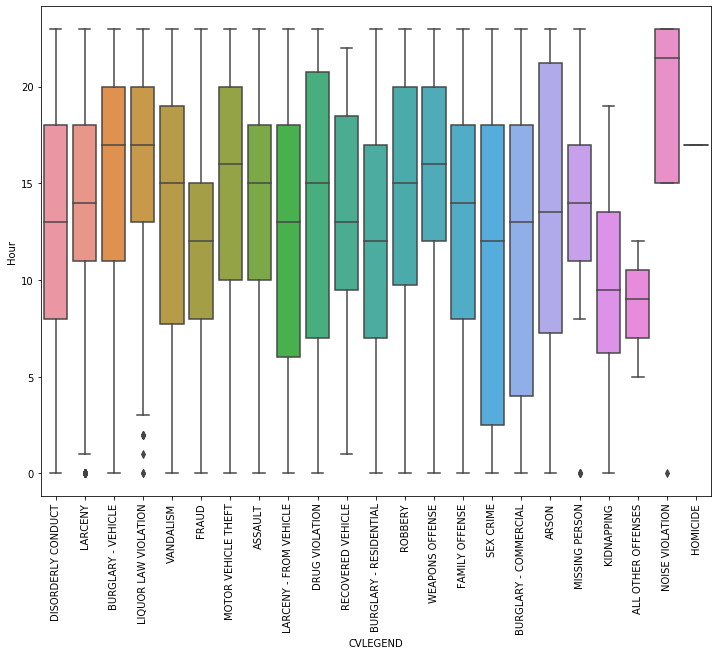

In [171]:
answer7 = 'SEX CRIME'

# Todo: Make a boxplot with seaborn
ax = sns.boxplot(x = calls['CVLEGEND'], y =calls['Hour'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Congratulations

Congrats! You are finished with this assignment.